In [1]:
import csv
import datetime
import numpy as np
import time
import sys
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import matplotlib
from matplotlib_venn import venn3
from PIL import Image, ImageDraw, ImageFont

In [2]:
def get_pct(num, denom):
    return str(round((num*1.0/denom)*100, 2)) + "%"

Put the information into an list

In [3]:
items = []

In [4]:
count = 0
headers = None
#with open("test.tsv", 'rt') as csvfile:
with open("AdIntuitionData.tsv", 'rt') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        count += 1
        if count == 1:
            headers = row
            continue
        items.append(row)

In [5]:
print headers

['xid', 'action', 'UserId', 'time', 'highlighted', 'video']


# How often does the average user see affiliate marketing

In [6]:
total_videos_watched = 0
aff_videos_watched = 0
time_diff = 4
vid_dups = 0
max_dt = 0
videos_by_user = {} #user: time (rounded to within x seconds either way): video
tot_vids_by_user = {}
for item in items:
    uid = item[2]
    ti = int(item[3])
    if ti > max_dt:
        max_dt = ti
    action = item[1]
    vid_id = item[5]
    video = item[5]
    action = item[1]
    if uid not in videos_by_user:
        videos_by_user[uid] = {}
    if action == 'vid_watch':
        total_videos_watched += 1
        if uid not in tot_vids_by_user:
            tot_vids_by_user[uid] = 0
        tot_vids_by_user[uid] += 1
    if action not in ['aff', 'utm', 'coupon_code']:
        continue
    found = False
    for i in range(ti-time_diff, ti+time_diff):
        if i in videos_by_user[uid]:
            if vid_id in videos_by_user[uid][i]:
                vid_dups += 1 #number of times that highlights happen on a vid
            else:
                videos_by_user[uid][i].append(vid_id)
                aff_videos_watched += 1
            found = True
            continue  
    if not found:
        videos_by_user[uid][ti] = [vid_id]
        aff_videos_watched += 1

In [7]:
d = datetime.datetime.fromtimestamp(max_dt).strftime('%m/%d/%Y %H:%M:%S')
print "Most recent data entry: " + d

Most recent data entry: 07/24/2019 07:36:03


In [8]:
aff_num = str(aff_videos_watched) + " videos with affiliate marketing"
print aff_num
tot = str(total_videos_watched) + " videos total watched"
print tot
affiliate_percent = get_pct(aff_videos_watched, total_videos_watched)
print affiliate_percent

1993 videos with affiliate marketing
13547 videos total watched
14.71%


# Is the average accurate?

In [9]:
tot_seen = []
aff_seen = []

In [10]:
for user in tot_vids_by_user.keys():
    affs = 0
    if user in videos_by_user:
        for moment in videos_by_user[user]:
            for vid in videos_by_user[user][moment]:
                affs += 1
    tot_seen.append(tot_vids_by_user[user])
    aff_seen.append(affs)

In [11]:
#Create a line of best fit
z = np.polyfit(tot_seen, aff_seen, 1)
p = np.poly1d(z) #this gives us a function for the averages
average_vals_x = []
average_vals_y = []
i = 0
while i < max(tot_seen):
    average_vals_x.append(i)
    average_vals_y.append(p(i))
    if i < 50:
        i += 1
    else:
        i += 5

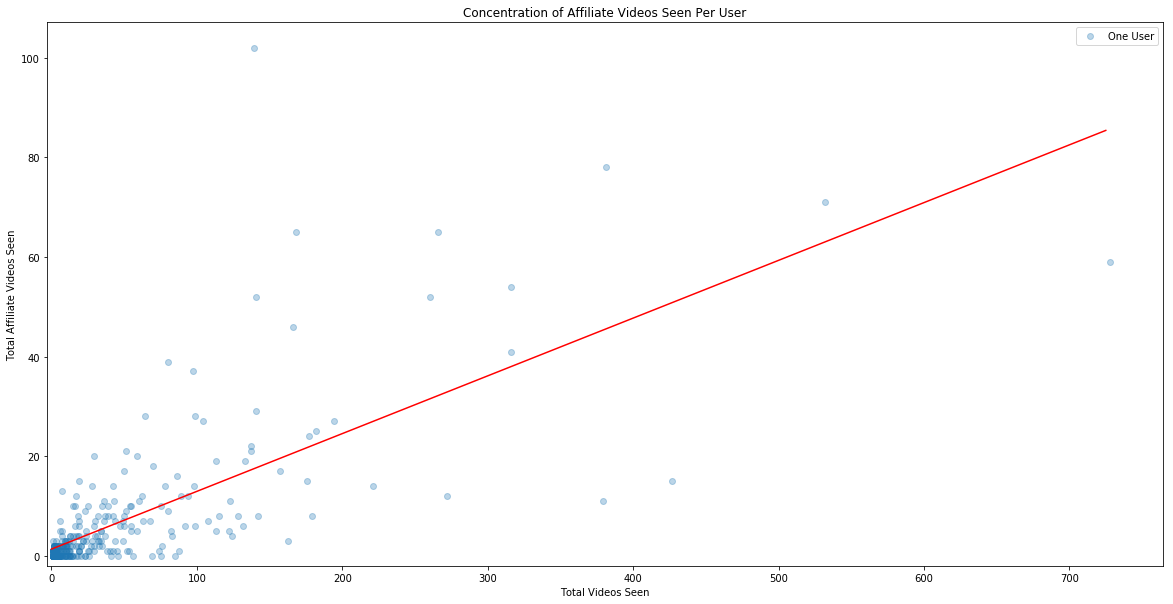

In [12]:
plt.figure(figsize=(20,10))
plt.scatter(tot_seen, aff_seen, alpha=0.3)
plt.plot(average_vals_x, average_vals_y, "r-", label='Line of Best Fit')
plt.title('Concentration of Affiliate Videos Seen Per User')
plt.xlabel('Total Videos Seen')
plt.ylabel('Total Affiliate Videos Seen')
plt.xlim(-3)
plt.ylim(-2)
plt.legend([
    matplotlib.lines.Line2D([], [], marker='.', alpha=0.3, linestyle='None',markersize=12, label='One User')], ['One User'])
plt.show()

In [13]:
med_tot_seen = statistics.median(tot_seen)
med_aff_seen = statistics.median(aff_seen)
print "median affiliate/median total videos seen"
print str(med_aff_seen) + "/" + str(med_tot_seen)
print get_pct(med_aff_seen, med_tot_seen)

median affiliate/median total videos seen
2/13
15.38%


In [14]:
med_tot_seen = statistics.mean(tot_seen)
med_aff_seen = statistics.mean(aff_seen)
print "mean affiliate/mean total videos seen"
print str(round(med_aff_seen,2)) + "/" + str(round(med_tot_seen,2))
print get_pct(med_aff_seen, med_tot_seen) # this should match the number found above

mean affiliate/mean total videos seen
6.37/43.28
14.71%


# What happens when we begin only looking at top users?

In [15]:
# number of days that a user has been active
users = {}
for item in items:
    uid = item[2]
    ti = int(item[3])
    t = datetime.datetime.fromtimestamp(ti).strftime('%Y-%m-%d')
    if uid not in users:
        users[uid] = {}
    if t not in users[uid]:
        users[uid][t] = 0
    users[uid][t] += 1

In [16]:
number_of_days_active = {}
total_users = 0
for user in users:
    total_users += 1
    days_active = len(users[user].keys())
    if days_active not in number_of_days_active:
        number_of_days_active[days_active] = 0
    number_of_days_active[days_active] += 1

In [35]:
print total_users

391


In [18]:
#we want to check multiple limits, but do not want our pool of users to get too small
total_users_i = total_users
max_days_active = 0
PERCENTAGE_OF_TOP_USERS_TO_STOP_AT = total_users*1.0/10
for days_active in sorted(number_of_days_active.keys()):
    total_users_i -= number_of_days_active[days_active]
    max_days_active = days_active
    if total_users_i < PERCENTAGE_OF_TOP_USERS_TO_STOP_AT:
        break

In [19]:
def get_metrics_for_days_active(min_days_active):
    tot_seen = []
    aff_seen = []
    for user in tot_vids_by_user.keys():
        affs = 0
        if user in videos_by_user:
            if len(users[user].keys()) <= min_days_active:
                continue
            for moment in videos_by_user[user]:
                for vid in videos_by_user[user][moment]:
                    affs += 1
        tot_seen.append(tot_vids_by_user[user])
        aff_seen.append(affs)
    med_tot_seen = statistics.median(tot_seen)
    med_aff_seen = statistics.median(aff_seen)
    mean_tot_seen = statistics.mean(tot_seen)
    mean_aff_seen = statistics.mean(aff_seen)
    return med_tot_seen, med_aff_seen, mean_tot_seen, mean_aff_seen

In [20]:
limit_of_days = []
median_pct = []
mean_pct = []
for i in range(0,max_days_active):
    tot, aff, totm, affm = get_metrics_for_days_active(i)
    limit_of_days.append(i)
    mean_pct.append((affm*1.0)/totm)
    median_pct.append((aff*1.0)/tot)

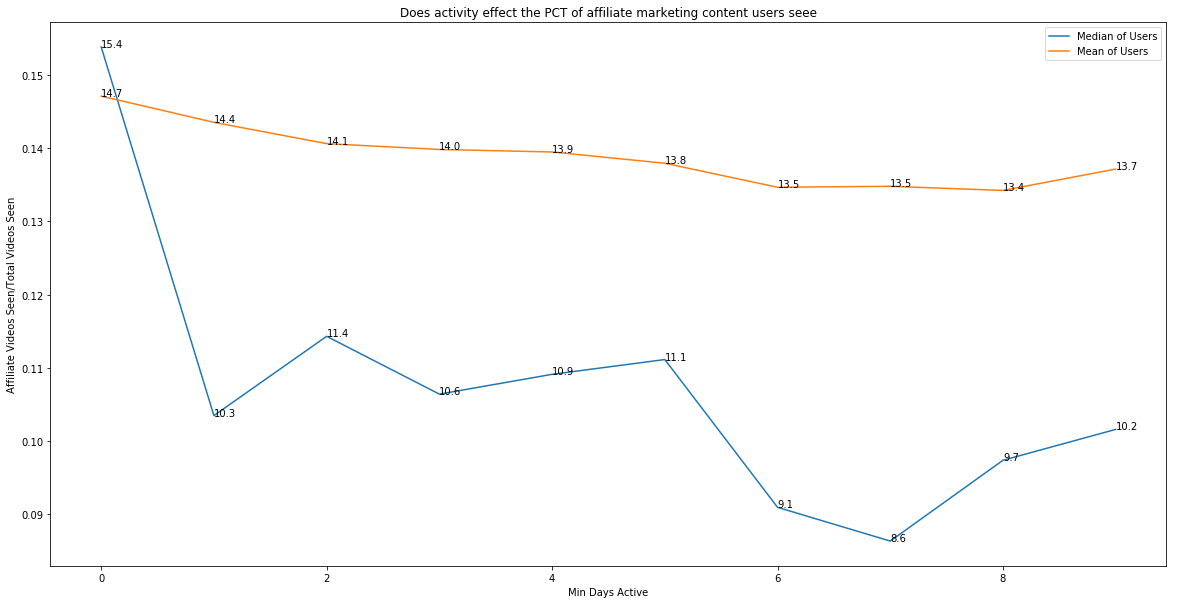

In [21]:
plt.figure(figsize=(20,10))
plt.plot(limit_of_days, median_pct, label="Median of Users")
plt.plot(limit_of_days, mean_pct, label="Mean of Users")
plt.legend()
plt.title("Does activity effect the PCT of affiliate marketing content users seee")
plt.xlabel('Min Days Active')
plt.ylabel('Affiliate Videos Seen/Total Videos Seen')
for i in range(len(limit_of_days)):
    if mean_pct[i] > 0:
        plt.annotate(str(round(mean_pct[i],3)*100), (limit_of_days[i], mean_pct[i]))
for i in range(len(limit_of_days)):
    if median_pct[i] > 0:
        plt.annotate(str(round(median_pct[i],3)*100), (limit_of_days[i], median_pct[i]))
plt.show()

# Breakdown of Types of Affiliate Marketing per Video

In [22]:
seen_vids = {}
for item in items:
    vid_id = item[5]
    highlighted = item[4]
    action = item[1]
    if action not in ['aff', 'utm', 'coupon_code']:
        continue
    #check if video has been seen
    if vid_id not in seen_vids:
        seen_vids[vid_id] = {}
    #check if we already have this highlighted portion
    if highlighted not in seen_vids[vid_id]:
        seen_vids[vid_id][highlighted] = action       

In [23]:
total_aff_vids = len(seen_vids.keys())
print total_aff_vids

1525


In [24]:
#individuals
has_aff = 0
has_utm = 0
has_coup = 0

#duplicates
aff_utm = 0
aff_coup = 0
utm_coup = 0
all_three = 0

total_highlights = {}
aff_highlights = {}
utm_highlights = {}
coup_highlights = {}
for vid in seen_vids.keys():
    aff_present = 0
    utm_present = 0
    coup_present = 0
    #count up the values
    for highlight in seen_vids[vid].keys():
        if seen_vids[vid][highlight] == "aff":
            aff_present += 1
        elif seen_vids[vid][highlight] == "utm":
            utm_present += 1
        elif seen_vids[vid][highlight] == "coupon_code":
            coup_present += 1
    #check the combinations
    if aff_present != 0:
        has_aff += 1
        if utm_present != 0:
            aff_utm += 1
            if coup_present != 0:
                all_three += 1
        if coup_present != 0:
            aff_coup += 1
    if utm_present != 0:
        has_utm += 1
        if coup_present != 0:
            utm_coup += 1
    if coup_present != 0:
        has_coup += 1
    
    # add to the lists
    highlights_in_this_video = coup_present + utm_present + aff_present
    if highlights_in_this_video not in total_highlights:
        total_highlights[highlights_in_this_video] = 0
    total_highlights[highlights_in_this_video] += 1
    if aff_present != 0:
        if aff_present not in aff_highlights:
            aff_highlights[aff_present] = 0
        aff_highlights[aff_present] += 1
    if utm_present != 0:
        if utm_present not in utm_highlights:
            utm_highlights[utm_present] = 0
        utm_highlights[utm_present] += 1
    if coup_present != 0:
        if coup_present not in coup_highlights:
            coup_highlights[coup_present] = 0
        coup_highlights[coup_present] += 1
        

In [25]:
print str(has_aff) + " videos with known aff links (" + get_pct(has_aff, total_aff_vids) + " of total)"
print str(has_utm) + " videos with utm params (" + get_pct(has_utm, total_aff_vids) + " of total)"
print str(has_coup) + " videos with coupon codes (" + get_pct(has_coup, total_aff_vids) + " of total)"

777 videos with known aff links (50.95% of total)
644 videos with utm params (42.23% of total)
410 videos with coupon codes (26.89% of total)


In [26]:
print str(aff_utm) + " videos with aff and utm (" + get_pct(aff_utm, total_aff_vids) + " of total)"
print str(aff_coup) + " videos with aff and coup (" + get_pct(aff_coup, total_aff_vids) + " of total)"
print str(utm_coup) + " videos with utm and coup (" + get_pct(utm_coup, total_aff_vids) + " of total)"
print str(all_three) + " videos with all three (" + get_pct(all_three, total_aff_vids) + " of total)"

124 videos with aff and utm (8.13% of total)
82 videos with aff and coup (5.38% of total)
140 videos with utm and coup (9.18% of total)
40 videos with all three (2.62% of total)


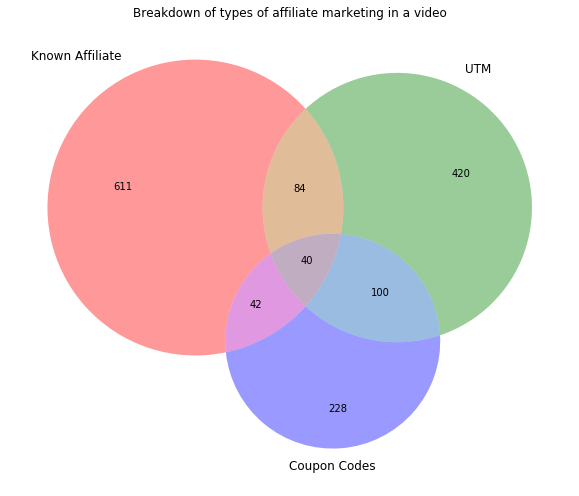

In [27]:
#get unique vals
only_aff_utm = aff_utm - all_three 
only_aff_coup = aff_coup - all_three
only_utm_coup = utm_coup - all_three

only_aff = has_aff - only_aff_utm - only_aff_coup - all_three
only_utm = has_utm - only_aff_utm - only_utm_coup - all_three
only_coup = has_coup - only_aff_coup - only_utm_coup - all_three

plt.figure(figsize=(10,10))
plt.title("Breakdown of types of affiliate marketing in a video")
p = venn3(
    #(A, B, AB, C, AC, BC, ABC)
    subsets = (only_aff, only_utm, only_aff_utm, only_coup, only_aff_coup, only_utm_coup, all_three), 
    set_labels = ('Known Affiliate', 'UTM', 'Coupon Codes')
)
plt.show()

# Number of Highlights per Video

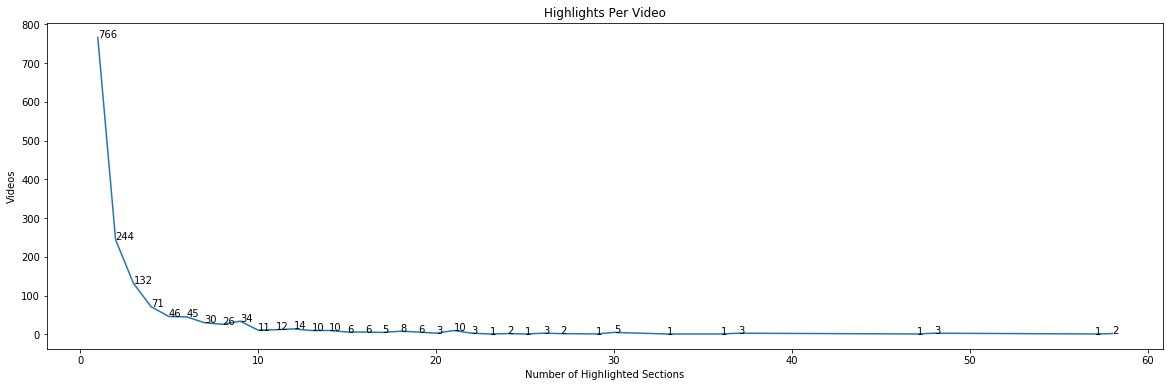

In [28]:
plt.figure(figsize=(20,6))
lists = sorted(total_highlights.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y)
plt.title("Highlights Per Video")
plt.ylabel('Videos')
plt.xlabel('Number of Highlighted Sections')
for i in range(len(x)):
    if y[i] > 0:
        plt.annotate(str(y[i]), (x[i], y[i]))
plt.show()

In [29]:
lines = {"Affiliates": aff_highlights, "UTMs": utm_highlights, "Coupons": coup_highlights}

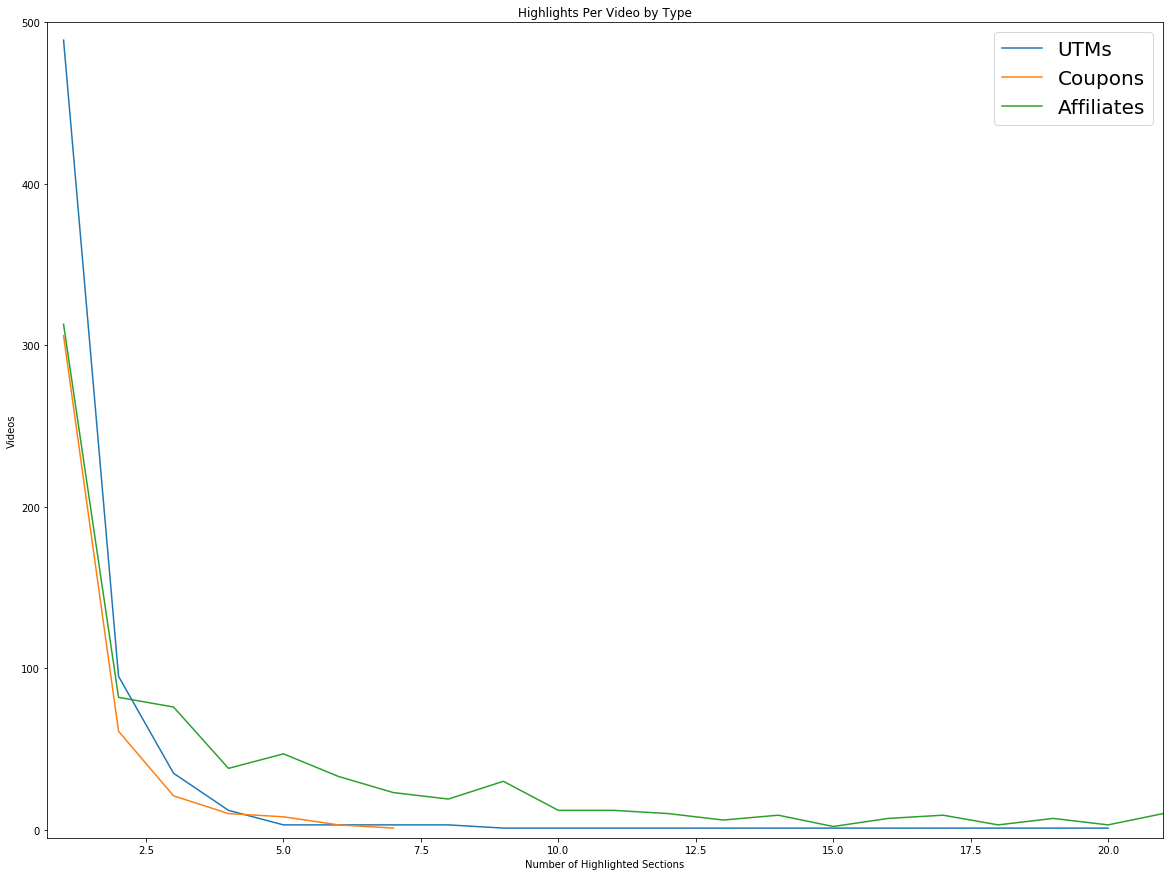

In [30]:
plt.figure(figsize=(20,15))
for kind in lines.keys():
    lists = sorted(lines[kind].items()) # sorted by key, return a list of tuples
    x, y = zip(*lists)
    plt.plot(x, y, label=kind)
plt.xlim(0.7,21)
plt.ylim(-5,500)
plt.title("Highlights Per Video by Type")
plt.legend(fontsize=20)
plt.ylabel('Videos')
plt.xlabel('Number of Highlighted Sections')
plt.show()

# Views Per Video

In [42]:
views_by_video = {}
for user in videos_by_user.keys():
    for t in videos_by_user[user].keys():
        for video in videos_by_user[user][t]:
            if video not in views_by_video:
                views_by_video[video] = 0
            views_by_video[video] += 1

In [52]:
views_breakdown = {}
for vid in views_by_video:
    views = views_by_video[vid]
    if views not in views_breakdown:
        views_breakdown[views] = 0
    views_breakdown[views] += 1

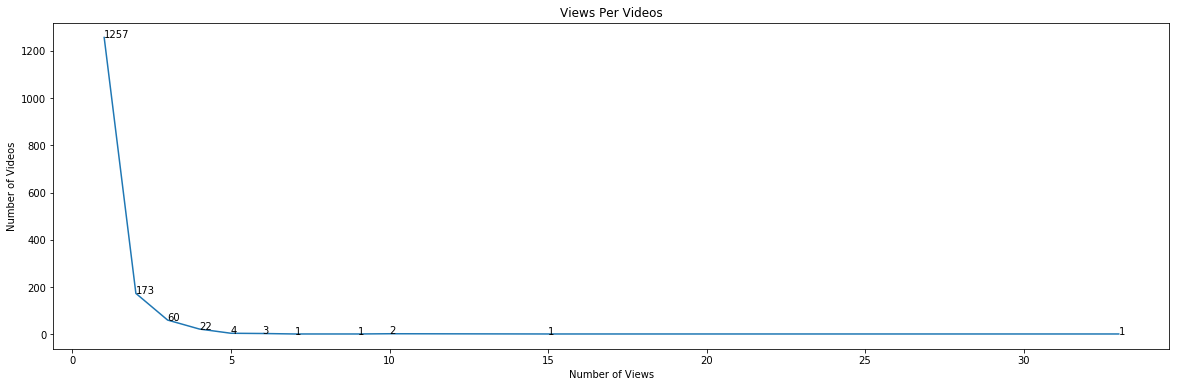

In [53]:
plt.figure(figsize=(20,6))
lists = sorted(views_breakdown.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
plt.plot(x, y)
plt.title("Views Per Videos")
plt.ylabel('Number of Videos')
plt.xlabel('Number of Views')
for i in range(len(x)):
    if y[i] > 0:
        plt.annotate(str(y[i]), (x[i], y[i]))
plt.show()

# Export

In [31]:
coupon_code_list = []
videos_list = []
for vid in seen_vids.keys():
    for highlight in seen_vids[vid].keys():
        if seen_vids[vid][highlight] == "coupon_code":
            coupon_code_list.append(highlight)
        videos_list.append([vid, highlight, seen_vids[vid][highlight]])

In [32]:
with open("coupons.tsv", 'w+') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    for cc in coupon_code_list:
        writer.writerow([cc])

In [33]:
with open("videos.tsv", 'w+') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(["vid","highlighted","type"])
    for item in videos_list:
        writer.writerow(item)